# best kaggle scores:
### 91.36% AUC - part 7, catboost
### 88.21% AUC - part 5, logistic regression with L1 regularization (k-fold target encoding)
### 87.3% AUC - part 6, gradient boosting (weight of evidence)

### In this notebook we will have a deeper look at all the features and eliminate redundant features if any. Also we will check if we can make additional features that might improve the performance.

In [98]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt       
%matplotlib inline 
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from catboost import CatBoostClassifier
from catboost import Pool

In [99]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

train.rename(columns=str.lower,inplace=True)
test.rename(columns=str.lower,inplace=True)

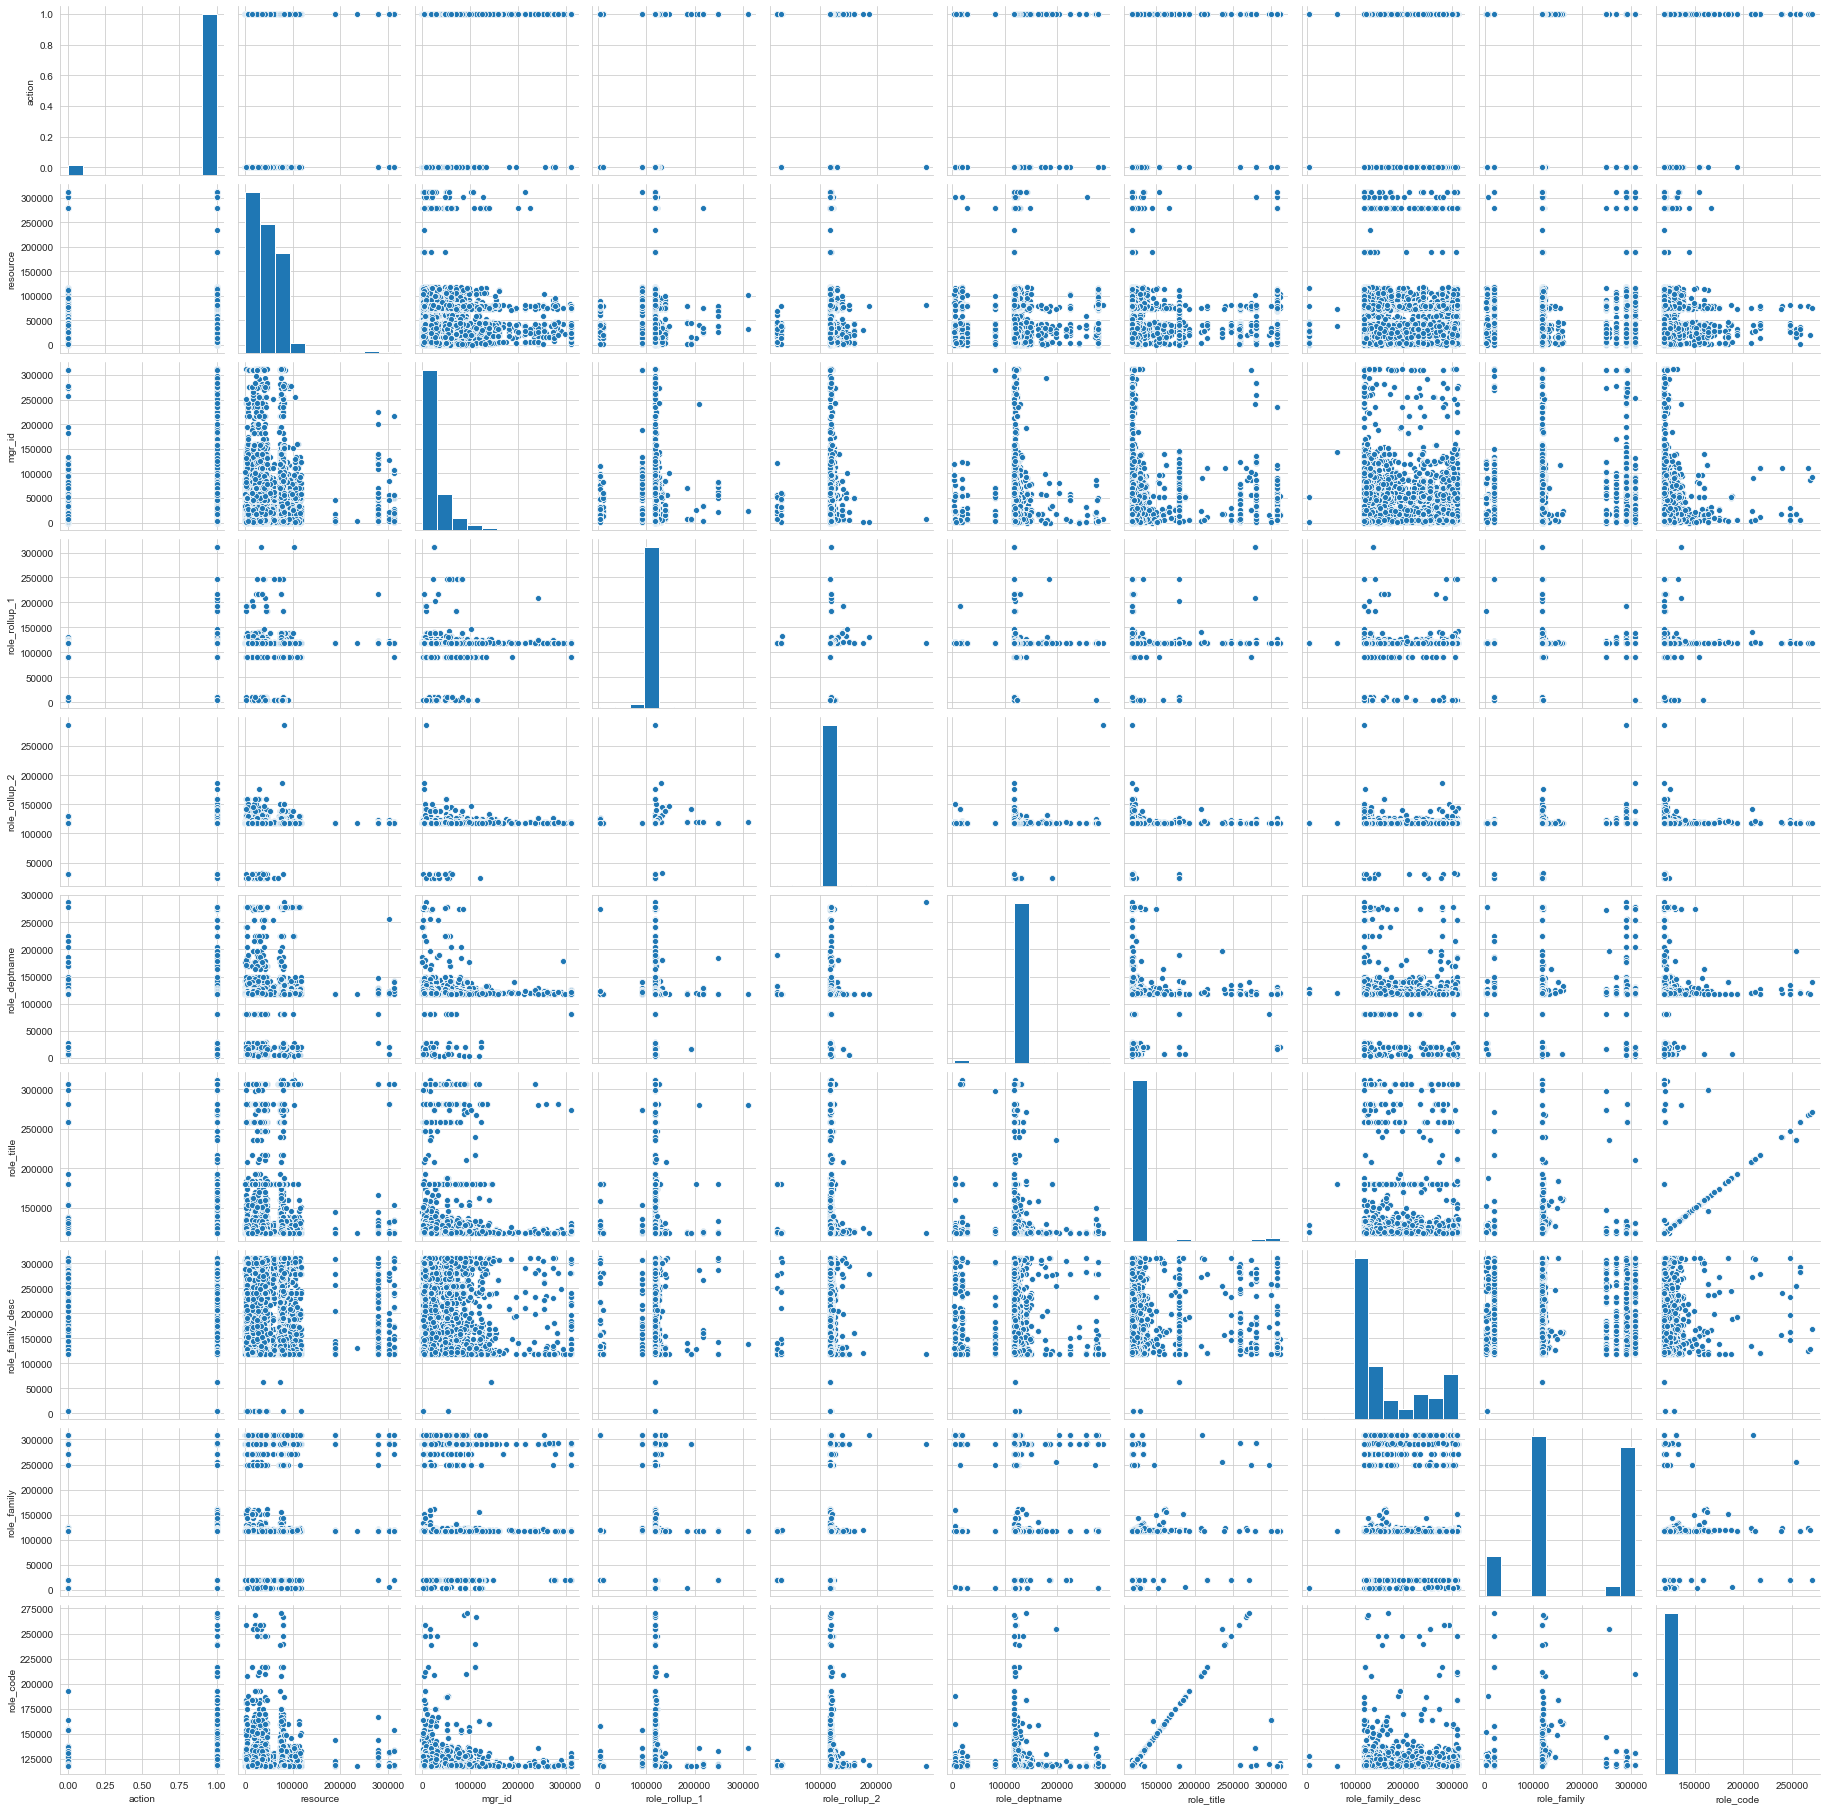

In [75]:
sns.pairplot(train)

**Looking at the pair plot above we see a weird trend in role_code and role_title**

In [100]:
def check_mappings(col1,col2):
    
    print("grouped by "+col1+" first then by "+col2)
    df1 = train.groupby([col1,col2]).count().reset_index()[[col1,col2]]
    display(df1)
    print("")
    
    print("grouped by "+col2+" first then by "+col1)
    df2 = train.groupby([col2,col1]).count().reset_index()[[col1,col2]]
    display(df2)
    print("")
    
    print("left join of df1(L) and df2[R]")
    s1 = pd.merge(df1,df2,on=col1,how="left")
    print(s1[col2+'_x'].equals(s1[col2+'_y']))
    print(s1.isnull().sum())
    display(s1)
    print("")
    
    print("left join of df2(L) and df1[R]")
    s2 = pd.merge(df2,df1,on=col1,how="left")
    print(s2[col2+'_x'].equals(s2[col2+'_y']))
    print(s2.isnull().sum())
    display(s2)

In [101]:
check_mappings("role_code","role_title")

grouped by role_code first then by role_title


,role_code,role_title
0,117880,117879
1,117888,117885
2,117898,117896
3,117900,117899
4,117908,117905
...,...,...
338,254396,235351
339,258436,258434
340,266863,266862
341,268610,268608



grouped by role_title first then by role_code


,role_code,role_title
0,117880,117879
1,117888,117885
2,117898,117896
3,117900,117899
4,117908,117905
...,...,...
338,119817,297560
339,163732,299559
340,118332,307024
341,121395,310825



left join of df1(L) and df2[R]
True
role_code       0
role_title_x    0
role_title_y    0
dtype: int64


,role_code,role_title_x,role_title_y
0,117880,117879,117879
1,117888,117885,117885
2,117898,117896,117896
3,117900,117899,117899
4,117908,117905,117905
...,...,...,...
338,254396,235351,235351
339,258436,258434,258434
340,266863,266862,266862
341,268610,268608,268608



left join of df2(L) and df1[R]
True
role_code       0
role_title_x    0
role_title_y    0
dtype: int64


,role_code,role_title_x,role_title_y
0,117880,117879,117879
1,117888,117885,117885
2,117898,117896,117896
3,117900,117899,117899
4,117908,117905,117905
...,...,...,...
338,119817,297560,297560
339,163732,299559,299559
340,118332,307024,307024
341,121395,310825,310825


**We can see that role_code and role_tite have 1 to 1 mapping. Therefore these two columns represent same information. Hence we can drop one of them.**

In [102]:
train.drop("role_code",axis=1,inplace=True)
test.drop("role_code",axis=1,inplace=True)

**Also if we look at the mappings among other features, we see that almost every pair has many to many relationship with each other**

In [103]:
from itertools import combinations
for i,j in combinations(train.columns[1:],2):
    check_mappings(i,j)
    print("################################################################################################")

grouped by resource first then by mgr_id


,resource,mgr_id
0,0,33
1,0,36
2,0,4417
3,0,4468
4,0,4583
...,...,...
27621,312139,3966
27622,312140,3966
27623,312152,4641
27624,312153,3048



grouped by mgr_id first then by resource


,resource,mgr_id
0,1937,25
1,4675,25
2,5452,25
3,6977,25
4,15740,25
...,...,...
27621,35790,311696
27622,35792,311696
27623,45444,311696
27624,73104,311696



left join of df1(L) and df2[R]
False
resource    0
mgr_id_x    0
mgr_id_y    0
dtype: int64


,resource,mgr_id_x,mgr_id_y
0,0,33,33
1,0,33,36
2,0,33,4417
3,0,33,4468
4,0,33,4583
...,...,...,...
1788537,312152,4641,4641
1788538,312153,3048,3048
1788539,312153,3048,50781
1788540,312153,50781,3048



left join of df2(L) and df1[R]
False
resource    0
mgr_id_x    0
mgr_id_y    0
dtype: int64


,resource,mgr_id_x,mgr_id_y
0,1937,25,25
1,1937,25,1080
2,1937,25,1088
3,1937,25,1475
4,1937,25,1483
...,...,...,...
1788537,45444,311696,124899
1788538,45444,311696,311696
1788539,73104,311696,311696
1788540,77321,311696,1216


################################################################################################
grouped by resource first then by role_rollup_1


,resource,role_rollup_1
0,0,117961
1,38,117961
2,38,119062
3,38,119920
4,38,121785
...,...,...
11086,312139,117961
11087,312140,117961
11088,312152,117961
11089,312153,91261



grouped by role_rollup_1 first then by resource


,resource,role_rollup_1
0,1937,4292
1,1969,4292
2,15739,4292
3,25098,4292
4,25883,4292
...,...,...
11086,74302,247952
11087,78178,247952
11088,78955,247952
11089,33423,311178



left join of df1(L) and df2[R]
False
resource           0
role_rollup_1_x    0
role_rollup_1_y    0
dtype: int64


,resource,role_rollup_1_x,role_rollup_1_y
0,0,117961,117961
1,38,117961,117961
2,38,117961,119062
3,38,117961,119920
4,38,117961,121785
...,...,...,...
46804,312152,117961,117961
46805,312153,91261,91261
46806,312153,91261,119062
46807,312153,119062,91261



left join of df2(L) and df1[R]
False
resource           0
role_rollup_1_x    0
role_rollup_1_y    0
dtype: int64


,resource,role_rollup_1_x,role_rollup_1_y
0,1937,4292,4292
1,1937,4292,91261
2,1937,4292,117902
3,1937,4292,117910
4,1937,4292,117951
...,...,...,...
46804,78955,247952,247952
46805,33423,311178,117961
46806,33423,311178,119134
46807,33423,311178,311178


################################################################################################
grouped by resource first then by role_rollup_2


,resource,role_rollup_2
0,0,118386
1,0,118413
2,38,118327
3,38,119063
4,38,119921
...,...,...
13417,312139,118343
13418,312140,118343
13419,312152,118343
13420,312153,118026



grouped by role_rollup_2 first then by resource


,resource,role_rollup_2
0,917,23779
1,1969,23779
2,6502,23779
3,15701,23779
4,20349,23779
...,...,...
13417,43083,159716
13418,44769,159716
13419,29693,176316
13420,78360,185842



left join of df1(L) and df2[R]
False
resource           0
role_rollup_2_x    0
role_rollup_2_y    0
dtype: int64


,resource,role_rollup_2_x,role_rollup_2_y
0,0,118386,118386
1,0,118386,118413
2,0,118413,118386
3,0,118413,118413
4,38,118327,118327
...,...,...,...
83105,312152,118343,118343
83106,312153,118026,118026
83107,312153,118026,119091
83108,312153,119091,118026



left join of df2(L) and df1[R]
False
resource           0
role_rollup_2_x    0
role_rollup_2_y    0
dtype: int64


,resource,role_rollup_2_x,role_rollup_2_y
0,917,23779,23779
1,917,23779,117903
2,917,23779,117962
3,917,23779,117969
4,917,23779,117981
...,...,...,...
83105,78360,185842,117962
83106,78360,185842,118327
83107,78360,185842,185842
83108,80859,286791,118446


################################################################################################
grouped by resource first then by role_deptname


,resource,role_deptname
0,0,118404
1,0,119968
2,0,120370
3,38,118933
4,38,119922
...,...,...
17349,312139,122012
17350,312140,122012
17351,312152,121747
17352,312153,119734



grouped by role_deptname first then by resource


,resource,role_deptname
0,684,4674
1,3853,4674
2,4672,4674
3,4674,4674
4,4675,4674
...,...,...
17349,112098,277693
17350,112874,277693
17351,114862,277693
17352,115529,277693



left join of df1(L) and df2[R]
False
resource           0
role_deptname_x    0
role_deptname_y    0
dtype: int64


,resource,role_deptname_x,role_deptname_y
0,0,118404,118404
1,0,118404,119968
2,0,118404,120370
3,0,119968,118404
4,0,119968,119968
...,...,...,...
361707,312152,121747,121747
361708,312153,119734,119734
361709,312153,119734,139759
361710,312153,139759,119734



left join of df2(L) and df1[R]
False
resource           0
role_deptname_x    0
role_deptname_y    0
dtype: int64


,resource,role_deptname_x,role_deptname_y
0,684,4674,4674
1,684,4674,16232
2,3853,4674,4674
3,3853,4674,6725
4,3853,4674,16232
...,...,...,...
361707,112874,277693,277693
361708,114862,277693,277693
361709,115529,277693,277693
361710,80859,286792,120317


################################################################################################
grouped by resource first then by role_title


,resource,role_title
0,0,117905
1,0,118321
2,0,118784
3,0,118841
4,38,117905
...,...,...
19038,312139,117905
19039,312140,117905
19040,312152,117905
19041,312153,117905



grouped by role_title first then by resource


,resource,role_title
0,256,117879
1,391,117879
2,917,117879
3,971,117879
4,972,117879
...,...,...
19038,98464,310825
19039,74867,311867
19040,78004,311867
19041,79121,311867



left join of df1(L) and df2[R]
False
resource        0
role_title_x    0
role_title_y    0
dtype: int64


,resource,role_title_x,role_title_y
0,0,117905,117905
1,0,117905,118321
2,0,117905,118784
3,0,117905,118841
4,0,118321,117905
...,...,...,...
217506,312152,117905,117905
217507,312153,117905,117905
217508,312153,117905,153957
217509,312153,153957,117905



left join of df2(L) and df1[R]
False
resource        0
role_title_x    0
role_title_y    0
dtype: int64


,resource,role_title_x,role_title_y
0,256,117879,117879
1,256,117879,117885
2,256,117879,118568
3,256,117879,179731
4,391,117879,117879
...,...,...,...
217506,79121,311867,159116
217507,79121,311867,258434
217508,79121,311867,307024
217509,79121,311867,311867


################################################################################################
grouped by resource first then by role_family_desc


,resource,role_family_desc
0,0,117906
1,0,118785
2,0,118842
3,0,123378
4,0,147114
...,...,...
22729,312139,240983
22730,312140,240983
22731,312152,117906
22732,312153,117906



grouped by role_family_desc first then by resource


,resource,role_family_desc
0,698,4673
1,1281,4673
2,4673,4673
3,6977,4673
4,17825,4673
...,...,...
22729,76436,311839
22730,16801,311867
22731,74588,311867
22732,75043,311867



left join of df1(L) and df2[R]
False
resource              0
role_family_desc_x    0
role_family_desc_y    0
dtype: int64


,resource,role_family_desc_x,role_family_desc_y
0,0,117906,117906
1,0,117906,118785
2,0,117906,118842
3,0,117906,123378
4,0,117906,147114
...,...,...,...
627199,312152,117906,117906
627200,312153,117906,117906
627201,312153,117906,155022
627202,312153,155022,117906



left join of df2(L) and df1[R]
False
resource              0
role_family_desc_x    0
role_family_desc_y    0
dtype: int64


,resource,role_family_desc_x,role_family_desc_y
0,698,4673,4673
1,698,4673,117906
2,698,4673,118959
3,698,4673,126485
4,698,4673,130134
...,...,...,...
627199,74588,311867,305057
627200,74588,311867,311867
627201,75043,311867,311867
627202,79628,311867,117906


################################################################################################
grouped by resource first then by role_family


,resource,role_family
0,0,118643
1,0,290919
2,38,290919
3,38,308574
4,136,290919
...,...,...
13190,312139,290919
13191,312140,290919
13192,312152,290919
13193,312153,118667



grouped by role_family first then by resource


,resource,role_family
0,836,3130
1,1020,3130
2,3130,3130
3,3853,3130
4,4675,3130
...,...,...
13190,116761,308574
13191,189629,308574
13192,278393,308574
13193,302049,308574



left join of df1(L) and df2[R]
False
resource         0
role_family_x    0
role_family_y    0
dtype: int64


,resource,role_family_x,role_family_y
0,0,118643,118643
1,0,118643,290919
2,0,290919,118643
3,0,290919,290919
4,38,290919,290919
...,...,...,...
55538,312152,290919,290919
55539,312153,118667,118667
55540,312153,118667,290919
55541,312153,290919,118667



left join of df2(L) and df1[R]
False
resource         0
role_family_x    0
role_family_y    0
dtype: int64


,resource,role_family_x,role_family_y
0,836,3130,3130
1,836,3130,118643
2,836,3130,270488
3,836,3130,290919
4,1020,3130,3130
...,...,...,...
55538,302049,308574,290919
55539,302049,308574,292795
55540,302049,308574,308574
55541,312122,308574,118453


################################################################################################
grouped by mgr_id first then by role_rollup_1


,mgr_id,role_rollup_1
0,25,117961
1,27,117961
2,30,117961
3,32,117961
4,33,117961
...,...,...
4456,311597,117961
4457,311651,117980
4458,311682,119170
4459,311683,118887



grouped by role_rollup_1 first then by mgr_id


,mgr_id,role_rollup_1
0,2199,4292
1,75693,4292
2,2112,5110
3,7320,5110
4,7424,5110
...,...,...
4456,71912,247952
4457,80114,247952
4458,80413,247952
4459,83254,247952



left join of df1(L) and df2[R]
False
mgr_id             0
role_rollup_1_x    0
role_rollup_1_y    0
dtype: int64


,mgr_id,role_rollup_1_x,role_rollup_1_y
0,25,117961,117961
1,27,117961,117961
2,30,117961,117961
3,32,117961,117961
4,33,117961,117961
...,...,...,...
4988,311597,117961,117961
4989,311651,117980,117980
4990,311682,119170,119170
4991,311683,118887,118887



left join of df2(L) and df1[R]
False
mgr_id             0
role_rollup_1_x    0
role_rollup_1_y    0
dtype: int64


,mgr_id,role_rollup_1_x,role_rollup_1_y
0,2199,4292,4292
1,75693,4292,4292
2,75693,4292,117961
3,75693,4292,120883
4,2112,5110,5110
...,...,...,...
4988,80413,247952,118163
4989,80413,247952,247952
4990,83254,247952,118163
4991,83254,247952,247952


################################################################################################
grouped by mgr_id first then by role_rollup_2


,mgr_id,role_rollup_2
0,25,117962
1,27,118413
2,30,118413
3,32,118343
4,33,118413
...,...,...
4618,311651,118076
4619,311682,119171
4620,311683,118888
4621,311696,117903



grouped by role_rollup_2 first then by mgr_id


,mgr_id,role_rollup_2
0,6530,23779
1,17108,23779
2,23782,23779
3,23789,23779
4,34370,23779
...,...,...
4618,20604,151110
4619,49096,159716
4620,2209,176316
4621,2214,185842



left join of df1(L) and df2[R]
False
mgr_id             0
role_rollup_2_x    0
role_rollup_2_y    0
dtype: int64


,mgr_id,role_rollup_2_x,role_rollup_2_y
0,25,117962,117962
1,27,118413,118413
2,30,118413,118413
3,32,118343,118343
4,33,118413,118413
...,...,...,...
5552,311683,118888,118888
5553,311696,117903,117903
5554,311696,117903,118041
5555,311696,118041,117903



left join of df2(L) and df1[R]
False
mgr_id             0
role_rollup_2_x    0
role_rollup_2_y    0
dtype: int64


,mgr_id,role_rollup_2_x,role_rollup_2_y
0,6530,23779,23779
1,17108,23779,23779
2,17108,23779,118085
3,23782,23779,23779
4,23789,23779,23779
...,...,...,...
5552,49096,159716,159716
5553,2209,176316,176316
5554,2214,185842,118327
5555,2214,185842,185842


################################################################################################
grouped by mgr_id first then by role_deptname


,mgr_id,role_deptname
0,25,122224
1,27,120370
2,27,240766
3,30,120370
4,32,118514
...,...,...
5040,311597,120096
5041,311651,117920
5042,311682,121363
5043,311683,124656



grouped by role_deptname first then by mgr_id


,mgr_id,role_deptname
0,1505,4674
1,1510,4674
2,23185,4674
3,34001,4674
4,46149,4674
...,...,...
5040,2270,277693
5041,2286,277693
5042,2296,277693
5043,50801,277693



left join of df1(L) and df2[R]
False
mgr_id             0
role_deptname_x    0
role_deptname_y    0
dtype: int64


,mgr_id,role_deptname_x,role_deptname_y
0,25,122224,122224
1,27,120370,120370
2,27,120370,240766
3,27,240766,120370
4,27,240766,240766
...,...,...,...
7028,311597,120096,120096
7029,311651,117920,117920
7030,311682,121363,121363
7031,311683,124656,124656



left join of df2(L) and df1[R]
False
mgr_id             0
role_deptname_x    0
role_deptname_y    0
dtype: int64


,mgr_id,role_deptname_x,role_deptname_y
0,1505,4674,4674
1,1510,4674,4674
2,23185,4674,4674
3,34001,4674,4674
4,46149,4674,4674
...,...,...,...
7028,2286,277693,277693
7029,2296,277693,127522
7030,2296,277693,277693
7031,50801,277693,277693


################################################################################################
grouped by mgr_id first then by role_title


,mgr_id,role_title
0,25,117905
1,25,118321
2,25,118685
3,27,117905
4,27,118321
...,...,...
7479,311651,127389
7480,311682,131336
7481,311683,118422
7482,311696,118863



grouped by role_title first then by mgr_id


,mgr_id,role_title
0,547,117879
1,607,117879
2,656,117879
3,666,117879
4,1208,117879
...,...,...
7479,117710,307024
7480,234958,307024
7481,53208,310825
7482,15413,311867



left join of df1(L) and df2[R]
False
mgr_id          0
role_title_x    0
role_title_y    0
dtype: int64


,mgr_id,role_title_x,role_title_y
0,25,117905,117905
1,25,117905,118321
2,25,117905,118685
3,25,118321,117905
4,25,118321,118321
...,...,...,...
17493,311683,118422,118422
17494,311696,118863,118863
17495,311696,118863,120990
17496,311696,120990,118863



left join of df2(L) and df1[R]
False
mgr_id          0
role_title_x    0
role_title_y    0
dtype: int64


,mgr_id,role_title_x,role_title_y
0,547,117879,117879
1,547,117879,117885
2,607,117879,117879
3,656,117879,117879
4,656,117879,117885
...,...,...,...
17493,15413,311867,159116
17494,15413,311867,311867
17495,16802,311867,119997
17496,16802,311867,127589


################################################################################################
grouped by mgr_id first then by role_family_desc


,mgr_id,role_family_desc
0,25,117906
1,25,240983
2,25,279443
3,27,117906
4,27,123004
...,...,...
7968,311683,149364
7969,311696,120991
7970,311696,127778
7971,311696,142453



grouped by role_family_desc first then by mgr_id


,mgr_id,role_family_desc
0,783,4673
1,1311,4673
2,52687,4673
3,144107,62587
4,1208,117879
...,...,...
7968,15391,311792
7969,17262,311834
7970,3471,311839
7971,278581,311839



left join of df1(L) and df2[R]
False
mgr_id                0
role_family_desc_x    0
role_family_desc_y    0
dtype: int64


,mgr_id,role_family_desc_x,role_family_desc_y
0,25,117906,117906
1,25,117906,240983
2,25,117906,279443
3,25,240983,117906
4,25,240983,240983
...,...,...,...
21292,311696,142453,168896
21293,311696,168896,120991
21294,311696,168896,127778
21295,311696,168896,142453



left join of df2(L) and df1[R]
False
mgr_id                0
role_family_desc_x    0
role_family_desc_y    0
dtype: int64


,mgr_id,role_family_desc_x,role_family_desc_y
0,783,4673,4673
1,783,4673,126485
2,783,4673,302830
3,1311,4673,4673
4,1311,4673,123503
...,...,...,...
21292,3471,311839,311839
21293,278581,311839,311839
21294,16802,311867,118477
21295,16802,311867,278014


################################################################################################
grouped by mgr_id first then by role_family


,mgr_id,role_family
0,25,290919
1,25,308574
2,27,290919
3,27,308574
4,30,290919
...,...,...
5478,311597,290919
5479,311651,19721
5480,311682,118467
5481,311683,118424



grouped by role_family first then by mgr_id


,mgr_id,role_family
0,1915,3130
1,2944,3130
2,3145,3130
3,3151,3130
4,3152,3130
...,...,...
5478,111670,308574
5479,111685,308574
5480,117710,308574
5481,131489,308574



left join of df1(L) and df2[R]
False
mgr_id           0
role_family_x    0
role_family_y    0
dtype: int64


,mgr_id,role_family_x,role_family_y
0,25,290919,290919
1,25,290919,308574
2,25,308574,290919
3,25,308574,308574
4,27,290919,290919
...,...,...,...
8422,311597,290919,290919
8423,311651,19721,19721
8424,311682,118467,118467
8425,311683,118424,118424



left join of df2(L) and df1[R]
False
mgr_id           0
role_family_x    0
role_family_y    0
dtype: int64


,mgr_id,role_family_x,role_family_y
0,1915,3130,3130
1,1915,3130,118643
2,1915,3130,270488
3,1915,3130,290919
4,2944,3130,3130
...,...,...,...
8422,111685,308574,308574
8423,117710,308574,118331
8424,117710,308574,308574
8425,131489,308574,308574


################################################################################################
grouped by role_rollup_1 first then by role_rollup_2


,role_rollup_1,role_rollup_2
0,4292,124335
1,4292,126095
2,5110,117954
3,11146,118491
4,91261,118026
...,...,...
182,203209,119256
183,209434,119256
184,216705,119256
185,247952,118164



grouped by role_rollup_2 first then by role_rollup_1


,role_rollup_1,role_rollup_2
0,118074,23779
1,118185,31010
2,133430,32137
3,117876,117877
4,117882,117883
...,...,...
182,121005,151110
183,118212,159716
184,117887,176316
185,130684,185842



left join of df1(L) and df2[R]
False
role_rollup_1      0
role_rollup_2_x    0
role_rollup_2_y    0
dtype: int64


,role_rollup_1,role_rollup_2_x,role_rollup_2_y
0,4292,124335,124335
1,4292,124335,126095
2,4292,126095,124335
3,4292,126095,126095
4,5110,117954,117954
...,...,...,...
552,203209,119256,119256
553,209434,119256,119256
554,216705,119256,119256
555,247952,118164,118164



left join of df2(L) and df1[R]
False
role_rollup_1      0
role_rollup_2_x    0
role_rollup_2_y    0
dtype: int64


,role_rollup_1,role_rollup_2_x,role_rollup_2_y
0,118074,23779,23779
1,118185,31010,31010
2,118185,31010,131390
3,133430,32137,32137
4,117876,117877,117877
...,...,...,...
552,117961,286791,119256
553,117961,286791,119715
554,117961,286791,121019
555,117961,286791,126102


################################################################################################
grouped by role_rollup_1 first then by role_deptname


,role_rollup_1,role_deptname
0,4292,118378
1,4292,274241
2,5110,117878
3,5110,117895
4,5110,118810
...,...,...
1180,216705,124725
1181,216705,129526
1182,247952,117878
1183,247952,184402



grouped by role_deptname first then by role_rollup_1


,role_rollup_1,role_deptname
0,117961,4674
1,120140,4674
2,117961,5488
3,121005,5606
4,117961,6104
...,...,...
1180,117961,275600
1181,118212,275600
1182,117902,277693
1183,117961,277693



left join of df1(L) and df2[R]
False
role_rollup_1      0
role_deptname_x    0
role_deptname_y    0
dtype: int64


,role_rollup_1,role_deptname_x,role_deptname_y
0,4292,118378,118378
1,4292,118378,274241
2,4292,274241,118378
3,4292,274241,274241
4,5110,117878,117878
...,...,...,...
124688,247952,117878,117878
124689,247952,117878,184402
124690,247952,184402,117878
124691,247952,184402,184402



left join of df2(L) and df1[R]
False
role_rollup_1      0
role_deptname_x    0
role_deptname_y    0
dtype: int64


,role_rollup_1,role_deptname_x,role_deptname_y
0,117961,4674,4674
1,117961,4674,5488
2,117961,4674,6104
3,117961,4674,6725
4,117961,4674,16232
...,...,...,...
124688,117961,286792,253965
124689,117961,286792,274241
124690,117961,286792,275600
124691,117961,286792,277693


################################################################################################
grouped by role_rollup_1 first then by role_title


,role_rollup_1,role_title
0,4292,119192
1,4292,128093
2,4292,130060
3,4292,179731
4,5110,117879
...,...,...
1501,247952,118811
1502,247952,119778
1503,247952,133111
1504,247952,179731



grouped by role_title first then by role_rollup_1


,role_rollup_1,role_title
0,5110,117879
1,11146,117879
2,117876,117879
3,117882,117879
4,117890,117879
...,...,...
1501,119134,307024
1502,120864,307024
1503,127044,307024
1504,118602,310825



left join of df1(L) and df2[R]
False
role_rollup_1    0
role_title_x     0
role_title_y     0
dtype: int64


,role_rollup_1,role_title_x,role_title_y
0,4292,119192,119192
1,4292,119192,128093
2,4292,119192,130060
3,4292,119192,179731
4,4292,128093,119192
...,...,...,...
84167,247952,179731,118811
84168,247952,179731,119778
84169,247952,179731,133111
84170,247952,179731,179731



left join of df2(L) and df1[R]
False
role_rollup_1    0
role_title_x     0
role_title_y     0
dtype: int64


,role_rollup_1,role_title_x,role_title_y
0,5110,117879,117879
1,5110,117879,117885
2,5110,117879,117896
3,5110,117879,117899
4,5110,117879,117985
...,...,...,...
84167,117961,311867,279482
84168,117961,311867,280788
84169,117961,311867,299559
84170,117961,311867,307024


################################################################################################
grouped by role_rollup_1 first then by role_family_desc


,role_rollup_1,role_family_desc
0,4292,128198
1,4292,130061
2,4292,179731
3,4292,300603
4,5110,117897
...,...,...
3277,247952,141802
3278,247952,287816
3279,247952,306550
3280,247952,310825



grouped by role_family_desc first then by role_rollup_1


,role_rollup_1,role_family_desc
0,117961,4673
1,118090,62587
2,117876,117879
3,117890,117879
4,117932,117879
...,...,...
3277,117961,311782
3278,117961,311792
3279,119596,311834
3280,118169,311839



left join of df1(L) and df2[R]
False
role_rollup_1         0
role_family_desc_x    0
role_family_desc_y    0
dtype: int64


,role_rollup_1,role_family_desc_x,role_family_desc_y
0,4292,128198,128198
1,4292,128198,130061
2,4292,128198,179731
3,4292,128198,300603
4,4292,130061,128198
...,...,...,...
1396393,247952,310825,141802
1396394,247952,310825,287816
1396395,247952,310825,306550
1396396,247952,310825,310825



left join of df2(L) and df1[R]
False
role_rollup_1         0
role_family_desc_x    0
role_family_desc_y    0
dtype: int64


,role_rollup_1,role_family_desc_x,role_family_desc_y
0,117961,4673,4673
1,117961,4673,117905
2,117961,4673,117906
3,117961,4673,118040
4,117961,4673,118054
...,...,...,...
1396393,117961,311867,311701
1396394,117961,311867,311752
1396395,117961,311867,311782
1396396,117961,311867,311792


################################################################################################
grouped by role_rollup_1 first then by role_family


,role_rollup_1,role_family
0,4292,117887
1,4292,119184
2,4292,119772
3,5110,19721
4,5110,19793
...,...,...
745,247952,19721
746,247952,19793
747,247952,117887
748,247952,118870



grouped by role_family first then by role_rollup_1


,role_rollup_1,role_family
0,117961,3130
1,118315,3130
2,120342,3130
3,183723,3130
4,117902,4673
...,...,...
745,120140,308574
746,120342,308574
747,120864,308574
748,130684,308574



left join of df1(L) and df2[R]
False
role_rollup_1    0
role_family_x    0
role_family_y    0
dtype: int64


,role_rollup_1,role_family_x,role_family_y
0,4292,117887,117887
1,4292,117887,119184
2,4292,117887,119772
3,4292,119184,117887
4,4292,119184,119184
...,...,...,...
10289,247952,118870,19721
10290,247952,118870,19793
10291,247952,118870,117887
10292,247952,118870,118870



left join of df2(L) and df1[R]
False
role_rollup_1    0
role_family_x    0
role_family_y    0
dtype: int64


,role_rollup_1,role_family_x,role_family_y
0,117961,3130,3130
1,117961,3130,4673
2,117961,3130,6725
3,117961,3130,19721
4,117961,3130,19793
...,...,...,...
10289,138798,308574,117887
10290,138798,308574,118453
10291,138798,308574,118643
10292,138798,308574,290919


################################################################################################
grouped by role_rollup_2 first then by role_deptname


,role_rollup_2,role_deptname
0,23779,117884
1,23779,117920
2,23779,117941
3,23779,118810
4,23779,121458
...,...,...
1393,151110,5606
1394,159716,118378
1395,176316,118378
1396,185842,118552



grouped by role_deptname first then by role_rollup_2


,role_rollup_2,role_deptname
0,118327,4674
1,120141,4674
2,117962,5488
3,151110,5606
4,118343,6104
...,...,...
1393,118213,275600
1394,118225,275600
1395,117903,277693
1396,118413,277693



left join of df1(L) and df2[R]
False
role_rollup_2      0
role_deptname_x    0
role_deptname_y    0
dtype: int64


,role_rollup_2,role_deptname_x,role_deptname_y
0,23779,117884,117884
1,23779,117884,117920
2,23779,117884,117941
3,23779,117884,118810
4,23779,117884,121458
...,...,...,...
38035,151110,5606,5606
38036,159716,118378,118378
38037,176316,118378,118378
38038,185842,118552,118552



left join of df2(L) and df1[R]
False
role_rollup_2      0
role_deptname_x    0
role_deptname_y    0
dtype: int64


,role_rollup_2,role_deptname_x,role_deptname_y
0,118327,4674,4674
1,118327,4674,20807
2,118327,4674,117963
3,118327,4674,117970
4,118327,4674,118320
...,...,...,...
38035,118413,277693,128801
38036,118413,277693,130859
38037,118413,277693,240766
38038,118413,277693,277693


################################################################################################
grouped by role_rollup_2 first then by role_title


,role_rollup_2,role_title
0,23779,117879
1,23779,117885
2,23779,118368
3,23779,118568
4,23779,119192
...,...,...
2120,159716,118747
2121,159716,120952
2122,176316,124000
2123,185842,118685



grouped by role_title first then by role_rollup_2


,role_rollup_2,role_title
0,23779,117879
1,31010,117879
2,117877,117879
3,117883,117879
4,117891,117879
...,...,...
2120,121013,307024
2121,127045,307024
2122,118603,310825
2123,117969,311867



left join of df1(L) and df2[R]
False
role_rollup_2    0
role_title_x     0
role_title_y     0
dtype: int64


,role_rollup_2,role_title_x,role_title_y
0,23779,117879,117879
1,23779,117879,117885
2,23779,117879,118368
3,23779,117879,118568
4,23779,117879,119192
...,...,...,...
83798,159716,120952,118747
83799,159716,120952,120952
83800,176316,124000,124000
83801,185842,118685,118685



left join of df2(L) and df1[R]
False
role_rollup_2    0
role_title_x     0
role_title_y     0
dtype: int64


,role_rollup_2,role_title_x,role_title_y
0,23779,117879,117879
1,23779,117879,117885
2,23779,117879,118368
3,23779,117879,118568
4,23779,117879,119192
...,...,...,...
83798,118343,311867,179731
83799,118343,311867,192867
83800,118343,311867,258434
83801,118343,311867,307024


################################################################################################
grouped by role_rollup_2 first then by role_family_desc


,role_rollup_2,role_family_desc
0,23779,117886
1,23779,117913
2,23779,118368
3,23779,119192
4,23779,123191
...,...,...
3944,151110,294485
3945,159716,159717
3946,176316,119771
3947,185842,279443



grouped by role_family_desc first then by role_rollup_2


,role_rollup_2,role_family_desc
0,117962,4673
1,118413,4673
2,118091,62587
3,117877,117879
4,117891,117879
...,...,...
3944,118052,311782
3945,118052,311792
3946,119597,311834
3947,118170,311839



left join of df1(L) and df2[R]
False
role_rollup_2         0
role_family_desc_x    0
role_family_desc_y    0
dtype: int64


,role_rollup_2,role_family_desc_x,role_family_desc_y
0,23779,117886,117886
1,23779,117886,117913
2,23779,117886,118368
3,23779,117886,119192
4,23779,117886,123191
...,...,...,...
384534,151110,294485,294485
384535,159716,159717,159717
384536,176316,119771,119771
384537,185842,279443,279443



left join of df2(L) and df1[R]
False
role_rollup_2         0
role_family_desc_x    0
role_family_desc_y    0
dtype: int64


,role_rollup_2,role_family_desc_x,role_family_desc_y
0,117962,4673,4673
1,117962,4673,117905
2,117962,4673,117906
3,117962,4673,118054
4,117962,4673,118260
...,...,...,...
384534,118225,311867,311064
384535,118225,311867,311392
384536,118225,311867,311441
384537,118225,311867,311622


################################################################################################
grouped by role_rollup_2 first then by role_family


,role_rollup_2,role_family
0,23779,19721
1,23779,19793
2,23779,117887
3,23779,119184
4,31010,19721
...,...,...
1040,151110,290919
1041,159716,118453
1042,176316,119772
1043,185842,308574



grouped by role_family first then by role_rollup_2


,role_rollup_2,role_family
0,117962,3130
1,118052,3130
2,118225,3130
3,118300,3130
4,118316,3130
...,...,...
1040,120141,308574
1041,120343,308574
1042,120865,308574
1043,138799,308574



left join of df1(L) and df2[R]
False
role_rollup_2    0
role_family_x    0
role_family_y    0
dtype: int64


,role_rollup_2,role_family_x,role_family_y
0,23779,19721,19721
1,23779,19721,19793
2,23779,19721,117887
3,23779,19721,119184
4,23779,19793,19721
...,...,...,...
14364,151110,290919,290919
14365,159716,118453,118453
14366,176316,119772,119772
14367,185842,308574,308574



left join of df2(L) and df1[R]
False
role_rollup_2    0
role_family_x    0
role_family_y    0
dtype: int64


,role_rollup_2,role_family_x,role_family_y
0,117962,3130,3130
1,117962,3130,4673
2,117962,3130,19793
3,117962,3130,117887
4,117962,3130,118131
...,...,...,...
14364,138799,308574,118453
14365,138799,308574,118643
14366,138799,308574,290919
14367,138799,308574,308574


################################################################################################
grouped by role_deptname first then by role_title


,role_deptname,role_title
0,4674,117905
1,4674,118321
2,4674,118451
3,4674,118685
4,4674,118747
...,...,...
2941,277693,120773
2942,277693,120952
2943,277693,123737
2944,277693,128230



grouped by role_title first then by role_deptname


,role_deptname,role_title
0,117878,117879
1,117884,117879
2,117895,117879
3,117912,117879
4,117920,117879
...,...,...
2941,127491,307024
2942,131274,307024
2943,118810,310825
2944,19666,311867



left join of df1(L) and df2[R]
False
role_deptname    0
role_title_x     0
role_title_y     0
dtype: int64


,role_deptname,role_title_x,role_title_y
0,4674,117905,117905
1,4674,117905,118321
2,4674,117905,118451
3,4674,117905,118685
4,4674,117905,118747
...,...,...,...
35019,277693,128230,120773
35020,277693,128230,120952
35021,277693,128230,123737
35022,277693,128230,128230



left join of df2(L) and df1[R]
False
role_deptname    0
role_title_x     0
role_title_y     0
dtype: int64


,role_deptname,role_title_x,role_title_y
0,117878,117879,117879
1,117878,117879,117885
2,117878,117879,117899
3,117878,117879,118054
4,117878,117879,118370
...,...,...,...
35019,120270,311867,123045
35020,120270,311867,123648
35021,120270,311867,130637
35022,120270,311867,138019


################################################################################################
grouped by role_deptname first then by role_family_desc


,role_deptname,role_family_desc
0,4674,117906
1,4674,130134
2,4674,174486
3,4674,213944
4,4674,311622
...,...,...
4548,277693,130134
4549,277693,155692
4550,277693,279443
4551,277693,302830



grouped by role_family_desc first then by role_deptname


,role_deptname,role_family_desc
0,118910,4673
1,127522,4673
2,119424,62587
3,117878,117879
4,117884,117879
...,...,...
4548,119598,311782
4549,120304,311792
4550,119598,311834
4551,118042,311839



left join of df1(L) and df2[R]
False
role_deptname         0
role_family_desc_x    0
role_family_desc_y    0
dtype: int64


,role_deptname,role_family_desc_x,role_family_desc_y
0,4674,117906,117906
1,4674,117906,130134
2,4674,117906,174486
3,4674,117906,213944
4,4674,117906,311622
...,...,...,...
121830,277693,302830,130134
121831,277693,302830,155692
121832,277693,302830,279443
121833,277693,302830,302830



left join of df2(L) and df1[R]
False
role_deptname         0
role_family_desc_x    0
role_family_desc_y    0
dtype: int64


,role_deptname,role_family_desc_x,role_family_desc_y
0,118910,4673,4673
1,118910,4673,117906
2,118910,4673,118054
3,118910,4673,118368
4,118910,4673,118448
...,...,...,...
121830,120535,311867,269406
121831,120535,311867,300044
121832,120535,311867,305057
121833,120535,311867,311441


################################################################################################
grouped by role_deptname first then by role_family


,role_deptname,role_family
0,4674,118453
1,4674,290919
2,4674,308574
3,5488,117887
4,5488,118643
...,...,...
1608,277693,118453
1609,277693,118960
1610,277693,290919
1611,277693,308574



grouped by role_family first then by role_deptname


,role_deptname,role_family
0,16232,3130
1,19772,3130
2,28618,3130
3,81476,3130
4,118317,3130
...,...,...
1608,204054,308574
1609,225010,308574
1610,253965,308574
1611,274241,308574



left join of df1(L) and df2[R]
False
role_deptname    0
role_family_x    0
role_family_y    0
dtype: int64


,role_deptname,role_family_x,role_family_y
0,4674,118453,118453
1,4674,118453,290919
2,4674,118453,308574
3,4674,290919,118453
4,4674,290919,290919
...,...,...,...
9242,277693,308574,118453
9243,277693,308574,118960
9244,277693,308574,290919
9245,277693,308574,308574



left join of df2(L) and df1[R]
False
role_deptname    0
role_family_x    0
role_family_y    0
dtype: int64


,role_deptname,role_family_x,role_family_y
0,16232,3130,3130
1,16232,3130,4673
2,16232,3130,117887
3,16232,3130,118131
4,16232,3130,118331
...,...,...,...
9242,277693,308574,4673
9243,277693,308574,118453
9244,277693,308574,118960
9245,277693,308574,290919


################################################################################################
grouped by role_title first then by role_family_desc


,role_title,role_family_desc
0,117879,117879
1,117879,117886
2,117879,117897
3,117879,117913
4,117879,118077
...,...,...
3008,307024,310608
3009,307024,311622
3010,310825,149047
3011,311867,118477



grouped by role_family_desc first then by role_title


,role_title,role_family_desc
0,119346,4673
1,128230,4673
2,179731,62587
3,117879,117879
4,117885,117879
...,...,...
3008,119743,311782
3009,125405,311792
3010,135809,311834
3011,118563,311839



left join of df1(L) and df2[R]
False
role_title            0
role_family_desc_x    0
role_family_desc_y    0
dtype: int64


,role_title,role_family_desc_x,role_family_desc_y
0,117879,117879,117879
1,117879,117879,117886
2,117879,117879,117897
3,117879,117879,117913
4,117879,117879,118077
...,...,...,...
107898,310825,149047,149047
107899,311867,118477,118477
107900,311867,118477,130382
107901,311867,130382,118477



left join of df2(L) and df1[R]
False
role_title            0
role_family_desc_x    0
role_family_desc_y    0
dtype: int64


,role_title,role_family_desc_x,role_family_desc_y
0,119346,4673,4673
1,119346,4673,302830
2,128230,4673,4673
3,128230,4673,127596
4,128230,4673,131284
...,...,...,...
107898,118563,311839,194960
107899,118563,311839,221815
107900,118563,311839,233643
107901,118563,311839,311839


################################################################################################
grouped by role_title first then by role_family


,role_title,role_family
0,117879,19721
1,117885,117887
2,117896,117887
3,117899,19721
4,117905,290919
...,...,...
338,297560,249618
339,299559,118205
340,307024,118331
341,310825,117887



grouped by role_family first then by role_title


,role_title,role_family
0,119351,3130
1,119743,3130
2,122188,3130
3,122274,3130
4,122860,3130
...,...,...
338,118536,308574
339,118685,308574
340,118777,308574
341,130857,308574



left join of df1(L) and df2[R]
True
role_title       0
role_family_x    0
role_family_y    0
dtype: int64


,role_title,role_family_x,role_family_y
0,117879,19721,19721
1,117885,117887,117887
2,117896,117887,117887
3,117899,19721,19721
4,117905,290919,290919
...,...,...,...
338,297560,249618,249618
339,299559,118205,118205
340,307024,118331,118331
341,310825,117887,117887



left join of df2(L) and df1[R]
True
role_title       0
role_family_x    0
role_family_y    0
dtype: int64


,role_title,role_family_x,role_family_y
0,119351,3130,3130
1,119743,3130,3130
2,122188,3130,3130
3,122274,3130,3130
4,122860,3130,3130
...,...,...,...
338,118536,308574,308574
339,118685,308574,308574
340,118777,308574,308574
341,130857,308574,308574


################################################################################################
grouped by role_family_desc first then by role_family


,role_family_desc,role_family
0,4673,4673
1,62587,117887
2,117879,19721
3,117879,117887
4,117886,19721
...,...,...
2581,311782,3130
2582,311792,125407
2583,311834,118331
2584,311839,270488



grouped by role_family first then by role_family_desc


,role_family_desc,role_family
0,119352,3130
1,119743,3130
2,123417,3130
3,126359,3130
4,128787,3130
...,...,...
2581,301475,308574
2582,306530,308574
2583,308574,308574
2584,310608,308574



left join of df1(L) and df2[R]
False
role_family_desc    0
role_family_x       0
role_family_y       0
dtype: int64


,role_family_desc,role_family_x,role_family_y
0,4673,4673,4673
1,62587,117887,117887
2,117879,19721,19721
3,117879,19721,117887
4,117879,117887,19721
...,...,...,...
3251,311782,3130,3130
3252,311792,125407,125407
3253,311834,118331,118331
3254,311839,270488,270488



left join of df2(L) and df1[R]
False
role_family_desc    0
role_family_x       0
role_family_y       0
dtype: int64


,role_family_desc,role_family_x,role_family_y
0,119352,3130,3130
1,119743,3130,3130
2,123417,3130,3130
3,126359,3130,3130
4,128787,3130,3130
...,...,...,...
3251,310608,308574,308574
3252,311622,308574,118331
3253,311622,308574,118424
3254,311622,308574,118638


################################################################################################


**It looks like we can make use of higher degree interactions within our feature set. Other than mgr_id and resource, all the features reflect the role of the individual hence very likely these features will have higher order interactions.**

**In the previous parts we had transformed these categorical features (disguised as numerical :p) using a number of techniques like count encoding, target encoding, target encoding with k-fold and weight of evidence. We were able to achieve somewhere between 85.5% to 86.6% AUC on kaggle test set untill now.  In the following parts we will include higher order interactions and will encode the features with previous best encoding techniques which were WOE and k-fold target encoding.**

# PART 5
**In this part we will include the higher order interactions which seem very likely in this dataset. We will encode the features with k-fold target encoding.**

In [18]:
x = train[train.columns[1:]]
y = train["action"]

f_test = test[test.columns[1:]]

**we will include second degree features**

In [19]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)
x = poly.fit_transform(x)
f_test = poly.transform(f_test)


x=pd.DataFrame(x)
f_test=pd.DataFrame(f_test)
print(x.shape)
print(f_test.shape)

(32769, 44)
(58921, 44)


In [20]:
x["action"] = np.array(y)

In [21]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
tt = pd.DataFrame()

for tr_idx, val_idx in folds.split(x,y):
    
    train_fold = x.iloc[tr_idx]
    val_fold = x.iloc[val_idx]
    
    for cols in x.columns[:-1]:
        mappings = train_fold.groupby(by=cols).mean()['action']
        val_fold[str(cols)+"--new"] = val_fold[cols].map(mappings)
        val_fold[str(cols)+"--new"][val_fold[str(cols)+"--new"].isnull()] = train_fold["action"].mean()
    
    #display(val_fold)
    tt = tt.append(val_fold) #merging all validation sets
    

In [22]:
def kfold_mean_enc(col):
    mapp = tt.groupby(by=col).mean()[str(col)+"--new"]
    x[str(col)+"--new"] = x[col].map(mapp)
    f_test[str(col)+"--new"] = f_test[col].map(mapp)

In [23]:
for cols in x.columns[:-1]:
    kfold_mean_enc(cols)

In [24]:
for col in f_test.columns[44:]:
    f_test[col][f_test[col].isnull()] = x['action'].mean()

In [25]:
x = x[x.columns[45:]]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100, stratify=y)

f_test = f_test[f_test.columns[44:]]

In [26]:
print(x_train.shape)
print(x_test.shape)

(26215, 44)
(6554, 44)


**logistic regression**

In [27]:
cl = LogisticRegression(penalty="l1",class_weight="balanced",random_state=7,solver="liblinear")
cl.fit(x_train,y_train)
print(cl.score(x_train,y_train))
print(cl.score(x_test,y_test))

0.9400724775891665
0.9415624046383888


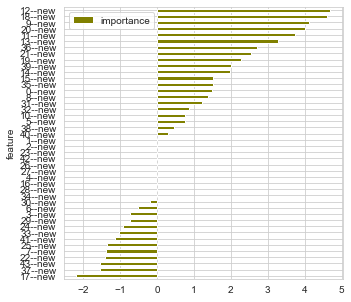

In [28]:
features = pd.DataFrame()
features['feature'] = x_train.columns
features['importance'] = cl.coef_[0]
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh',color="olive", figsize=(5, 5))

In [29]:
selected_feat = list(features[features['importance']>=1].index) + list(features[features['importance']<=-1].index)
print("selecting these many features: "+str(len(selected_feat)))
print(selected_feat)

selecting these many features: 24
['31--new', '8--new', '0--new', '35--new', '15--new', '14--new', '39--new', '19--new', '21--new', '36--new', '13--new', '11--new', '20--new', '9--new', '18--new', '12--new', '17--new', '37--new', '43--new', '22--new', '7--new', '25--new', '41--new', '33--new']


In [446]:
model = LogisticRegression(penalty = "l1",random_state=7,solver="liblinear")

param_dist = {"C": sp_randint(0.1, 100),
              "class_weight": [None,"balanced"]}
 
randomCV = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20,cv=10,random_state=7,scoring='roc_auc')
randomCV.fit(x_train[selected_feat], y_train)


best = randomCV.best_params_
print(best)
print("")



cl = LogisticRegression(penalty = "l1",C=best["C"],class_weight=best["class_weight"],random_state=7,solver="liblinear")
cl_roc = cross_val_score(cl, x_test[selected_feat], y_test, cv=10,scoring="roc_auc")
cl_pred = cross_val_predict(cl, x_test[selected_feat], y_test, cv=10)

print("auc after 10-fold cv: "+str(cl_roc.mean())+", SD: "+str(cl_roc.std()))

mat_train = confusion_matrix(y_test,cl_pred,labels=[1,0])
cl_cm = pd.DataFrame(mat_train, index = [i for i in ["Truth(given)","Truth(not given)"]],
                  columns = [i for i in ["Predict(given)","Predict(not given)"]])
cl_cm

{'C': 14, 'class_weight': 'balanced'}

auc after 10-fold cv: 0.9809967568301736, SD: 0.006958879130452499


,Predict(given),Predict(not given)
Truth(given),5826,349
Truth(not given),35,344


**randomforest**

In [32]:
cl = RandomForestClassifier(random_state=7)
cl.fit(x_train,y_train)
print(cl.score(x_train,y_train))
print(cl.score(x_test,y_test))

0.9977875262254434
0.9826060421116876


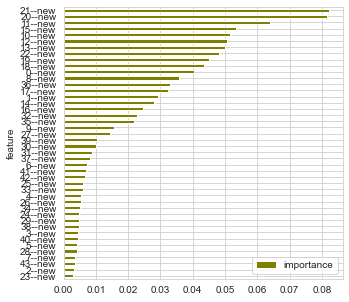

In [33]:
features = pd.DataFrame()
features['feature'] = x_train.columns
features['importance'] = cl.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh',color="olive", figsize=(5, 5))

In [34]:
selected_feat = list(features['importance'].sort_values(ascending=False).head(21).index)
print("selecting these many features: "+str(len(selected_feat)))
print(selected_feat)

selecting these many features: 21
['21--new', '20--new', '11--new', '15--new', '10--new', '12--new', '13--new', '22--new', '19--new', '18--new', '0--new', '8--new', '36--new', '17--new', '1--new', '14--new', '16--new', '32--new', '35--new', '9--new', '27--new']


In [393]:
model = RandomForestClassifier(random_state=7)

param_dist = {"max_depth":list(np.arange(2,30)),
              "class_weight":[None,"balanced"],
              "min_samples_leaf":[1,3,5,7],
              "criterion":['gini','entropy'],
              "max_features":list(np.arange(1,21))+['sqrt'],
              "n_estimators": np.arange(10,130,5)}
 
randomCV = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=40,cv=10,random_state=7,scoring='roc_auc')
randomCV.fit(x_train[selected_feat], y_train)


best = randomCV.best_params_
print(best)
print("")



cl = RandomForestClassifier(n_estimators=best["n_estimators"],max_depth=best["max_depth"],class_weight=best["class_weight"],min_samples_leaf=best["min_samples_leaf"],criterion=best["criterion"],max_features=best["max_features"],random_state=7)
cl_roc = cross_val_score(cl, x_test[selected_feat], y_test, cv=10,scoring="roc_auc")
cl_pred = cross_val_predict(cl, x_test[selected_feat], y_test, cv=10)

print("auc after 10-fold cv: "+str(cl_roc.mean())+", SD: "+str(cl_roc.std()))

mat_train = confusion_matrix(y_test,cl_pred,labels=[1,0])
cl_cm = pd.DataFrame(mat_train, index = [i for i in ["Truth(given)","Truth(not given)"]],
                  columns = [i for i in ["Predict(given)","Predict(not given)"]])
cl_cm

{'n_estimators': 125, 'min_samples_leaf': 5, 'max_features': 9, 'max_depth': 13, 'criterion': 'entropy', 'class_weight': None}

auc after 10-fold cv: 0.9920726023302157, SD: 0.004987670017171243


,Predict(given),Predict(not given)
Truth(given),6120,55
Truth(not given),72,307


**gradient boost**

In [37]:
cl = GradientBoostingClassifier(random_state=7)
cl.fit(x_train,y_train)
print(cl.score(x_train,y_train))
print(cl.score(x_test,y_test))

0.985084875071524
0.9824534635337199


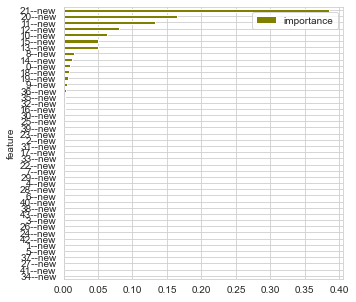

In [38]:
features = pd.DataFrame()
features['feature'] = x_train.columns
features['importance'] = cl.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh',color="olive", figsize=(5, 5))

In [39]:
selected_feat = list(features['importance'].sort_values(ascending=False).head(7).index)
print("selecting these many features: "+str(len(selected_feat)))
print(selected_feat)

selecting these many features: 7
['21--new', '20--new', '11--new', '12--new', '10--new', '15--new', '13--new']


In [405]:
model = GradientBoostingClassifier(random_state=7)

param_dist = {"max_depth":list(np.arange(2,20)),
              "max_features":list(np.arange(1,8)),
              "min_samples_leaf":[1,3,5,7,9],
              "learning_rate":[0.1,0.2,0.3,0.4,0.5],
              "n_estimators": np.arange(10,130,5)}
 
randomCV = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=40,cv=10,random_state=7,scoring='roc_auc')
randomCV.fit(x_train[selected_feat], y_train)


best = randomCV.best_params_
print(best)
print("")



cl = GradientBoostingClassifier(n_estimators=best["n_estimators"],min_samples_leaf=best["min_samples_leaf"],max_features=best["max_features"],max_depth=best["max_depth"],learning_rate=best["learning_rate"],random_state=7)
cl_roc = cross_val_score(cl, x_test[selected_feat], y_test, cv=10,scoring="roc_auc")
cl_pred = cross_val_predict(cl, x_test[selected_feat], y_test, cv=10)

print("auc after 10-fold cv: "+str(cl_roc.mean())+", SD: "+str(cl_roc.std()))

mat_train = confusion_matrix(y_test,cl_pred,labels=[1,0])
cl_cm = pd.DataFrame(mat_train, index = [i for i in ["Truth(given)","Truth(not given)"]],
                  columns = [i for i in ["Predict(given)","Predict(not given)"]])
cl_cm

{'n_estimators': 70, 'min_samples_leaf': 3, 'max_features': 2, 'max_depth': 6, 'learning_rate': 0.1}

auc after 10-fold cv: 0.9923126250927419, SD: 0.0034050989399206674


,Predict(given),Predict(not given)
Truth(given),6111,64
Truth(not given),84,295


**lets evaluate the model on the final kaggle test set**

In [31]:
# 88.21% (new best)

final_model = LogisticRegression(penalty = "l1",random_state=7,solver="liblinear",C=14,class_weight="balanced")
final_model.fit(x[selected_feat],y)
final_predictions = final_model.predict_proba(f_test[selected_feat])[:, 1]

submit = pd.DataFrame(columns=["Id","Action"])
submit["Action"] = final_predictions
submit["Id"] = test["id"]
#submit.to_csv('PT5-lr.csv',index=False)

In [35]:
# 71.8%

final_model = RandomForestClassifier(n_estimators=125, min_samples_leaf=5, max_features=9, criterion="entropy", random_state=7, max_depth=13,class_weight="balanced")
final_model.fit(x[selected_feat],y)
final_predictions = final_model.predict_proba(f_test[selected_feat])[:, 1]

submit = pd.DataFrame(columns=["Id","Action"])
submit["Action"] = final_predictions
submit["Id"] = test["id"]
# submit.to_csv('PT5-rf.csv',index=False)

In [40]:
# 82.9%

final_model = GradientBoostingClassifier(n_estimators=70,max_depth=6,max_features=2,min_samples_leaf=3,learning_rate=0.1,random_state=7)
final_model.fit(x[selected_feat],y)
final_predictions = final_model.predict_proba(f_test[selected_feat])[:, 1]

submit = pd.DataFrame(columns=["Id","Action"])
submit["Action"] = final_predictions
submit["Id"] = test["id"]
# submit.to_csv('PT5-gb.csv',index=False)

**We got the second best score after including higher order features.**
# PART 6
**Higher order interactions with WOE encoding.**

In [48]:
x = train[train.columns[1:]]
y = train["action"]

f_test = test[test.columns[1:]]

In [49]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2,interaction_only=False,include_bias=False)
x = poly.fit_transform(x)
f_test = poly.transform(f_test)


x=pd.DataFrame(x)
f_test=pd.DataFrame(f_test)
print(x.shape)
print(f_test.shape)

(32769, 44)
(58921, 44)


In [50]:
for c in x.columns:
    x[c] = x[c].astype("str")
    f_test[c] = f_test[c].astype("str")

In [51]:
import category_encoders as ce
woe_encoder = ce.WOEEncoder(x.columns.tolist())
x = woe_encoder.fit_transform(x, y)
f_test = woe_encoder.transform(f_test)

In [52]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100, stratify=y)

**logistic regression**

In [76]:
cl = LogisticRegression(penalty="l1",class_weight="balanced",random_state=7,solver="liblinear")
cl.fit(x_train,y_train)
print(cl.score(x_train,y_train))
print(cl.score(x_test,y_test))

0.895288956704177
0.8973146170277693


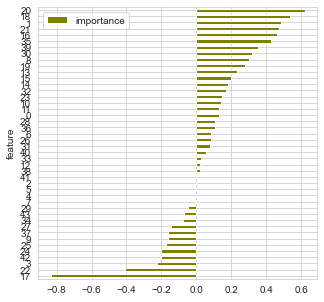

In [77]:
features = pd.DataFrame()
features['feature'] = x_train.columns
features['importance'] = cl.coef_[0]
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh',color="olive", figsize=(5, 5))

In [78]:
selected_feat = list(features[features['importance']>=0.2].index) + list(features[features['importance']<=-0.2].index)
print("selecting these many features: "+str(len(selected_feat)))
print(selected_feat)

selecting these many features: 15
[13, 19, 8, 30, 39, 35, 16, 21, 1, 18, 20, 17, 22, 3, 42]


In [59]:
model = LogisticRegression(penalty = "l1",random_state=7,solver="liblinear")

param_dist = {"C": sp_randint(0.1, 100),
              "class_weight": [None,"balanced"]}
 
randomCV = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=20,cv=10,random_state=7,scoring='roc_auc')
randomCV.fit(x_train[selected_feat], y_train)


best = randomCV.best_params_
print(best)
print("")



cl = LogisticRegression(penalty = "l1",C=best["C"],class_weight=best["class_weight"],random_state=7,solver="liblinear")
cl_roc = cross_val_score(cl, x_test[selected_feat], y_test, cv=10,scoring="roc_auc")
cl_pred = cross_val_predict(cl, x_test[selected_feat], y_test, cv=10)

print("auc after 10-fold cv: "+str(cl_roc.mean())+", SD: "+str(cl_roc.std()))

mat_train = confusion_matrix(y_test,cl_pred,labels=[1,0])
cl_cm = pd.DataFrame(mat_train, index = [i for i in ["Truth(given)","Truth(not given)"]],
                  columns = [i for i in ["Predict(given)","Predict(not given)"]])
cl_cm

{'C': 92, 'class_weight': 'balanced'}

auc after 10-fold cv: 0.944519680056845, SD: 0.018098723474198133


,Predict(given),Predict(not given)
Truth(given),5504,671
Truth(not given),55,324


**random forest**

0.9976349418271981
0.9749771132133048


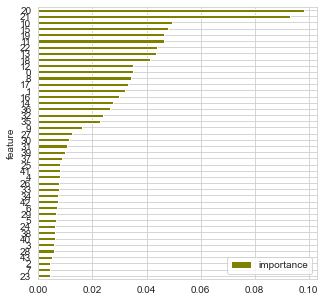

In [80]:
cl = RandomForestClassifier(random_state=7)
cl.fit(x_train,y_train)
print(cl.score(x_train,y_train))
print(cl.score(x_test,y_test))

features = pd.DataFrame()
features['feature'] = x_train.columns
features['importance'] = cl.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh',color="olive", figsize=(5, 5))

In [81]:
selected_feat = list(features['importance'].sort_values(ascending=False).head(19).index)
print("selecting these many features: "+str(len(selected_feat)))
print(selected_feat)

selecting these many features: 19
[20, 21, 10, 15, 19, 11, 22, 13, 18, 12, 0, 8, 17, 1, 16, 14, 36, 32, 35]


In [64]:
model = RandomForestClassifier(random_state=7)

param_dist = {"max_depth":list(np.arange(2,30)),
              "class_weight":[None,"balanced"],
              "min_samples_leaf":[1,3,5,7],
              "criterion":['gini','entropy'],
              "max_features":list(np.arange(1,21))+['sqrt'],
              "n_estimators": np.arange(10,130,5)}
 
randomCV = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=40,cv=10,random_state=7,scoring='roc_auc')
randomCV.fit(x_train[selected_feat], y_train)


best = randomCV.best_params_
print(best)
print("")



cl = RandomForestClassifier(n_estimators=best["n_estimators"],max_depth=best["max_depth"],class_weight=best["class_weight"],min_samples_leaf=best["min_samples_leaf"],criterion=best["criterion"],max_features=best["max_features"],random_state=7)
cl_roc = cross_val_score(cl, x_test[selected_feat], y_test, cv=10,scoring="roc_auc")
cl_pred = cross_val_predict(cl, x_test[selected_feat], y_test, cv=10)

print("auc after 10-fold cv: "+str(cl_roc.mean())+", SD: "+str(cl_roc.std()))

mat_train = confusion_matrix(y_test,cl_pred,labels=[1,0])
cl_cm = pd.DataFrame(mat_train, index = [i for i in ["Truth(given)","Truth(not given)"]],
                  columns = [i for i in ["Predict(given)","Predict(not given)"]])
cl_cm

{'n_estimators': 125, 'min_samples_leaf': 5, 'max_features': 9, 'max_depth': 13, 'criterion': 'entropy', 'class_weight': None}

auc after 10-fold cv: 0.9795774505325742, SD: 0.01017823586995799


,Predict(given),Predict(not given)
Truth(given),6120,55
Truth(not given),144,235


**gradient boost**

In [83]:
cl = GradientBoostingClassifier(random_state=7)
cl.fit(x_train,y_train)
print(cl.score(x_train,y_train))
print(cl.score(x_test,y_test))

0.9813465573145146
0.9772657918828197


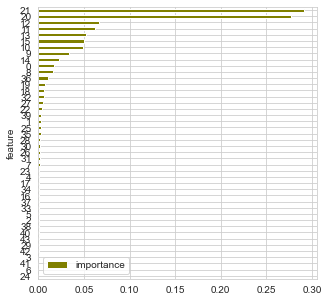

In [84]:
features = pd.DataFrame()
features['feature'] = x_train.columns
features['importance'] = cl.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh',color="olive", figsize=(5, 5))

In [85]:
selected_feat = list(features['importance'].sort_values(ascending=False).head(12).index)
print("selecting these many features: "+str(len(selected_feat)))
print(selected_feat)

selecting these many features: 12
[21, 20, 12, 11, 13, 15, 10, 9, 14, 0, 8, 36]


In [75]:
model = GradientBoostingClassifier(random_state=7)

param_dist = {"max_depth":list(np.arange(2,20)),
              "max_features":list(np.arange(1,13)),
              "min_samples_leaf":[1,3,5,7,9],
              "learning_rate":[0.1,0.2,0.3,0.4,0.5],
              "n_estimators": np.arange(10,130,5)}
 
randomCV = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=40,cv=10,random_state=7,scoring='roc_auc')
randomCV.fit(x_train[selected_feat], y_train)


best = randomCV.best_params_
print(best)
print("")



cl = GradientBoostingClassifier(n_estimators=best["n_estimators"],min_samples_leaf=best["min_samples_leaf"],max_features=best["max_features"],max_depth=best["max_depth"],learning_rate=best["learning_rate"],random_state=7)
cl_roc = cross_val_score(cl, x_test[selected_feat], y_test, cv=10,scoring="roc_auc")
cl_pred = cross_val_predict(cl, x_test[selected_feat], y_test, cv=10)

print("auc after 10-fold cv: "+str(cl_roc.mean())+", SD: "+str(cl_roc.std()))

mat_train = confusion_matrix(y_test,cl_pred,labels=[1,0])
cl_cm = pd.DataFrame(mat_train, index = [i for i in ["Truth(given)","Truth(not given)"]],
                  columns = [i for i in ["Predict(given)","Predict(not given)"]])
cl_cm

{'n_estimators': 110, 'min_samples_leaf': 7, 'max_features': 3, 'max_depth': 3, 'learning_rate': 0.2}

auc after 10-fold cv: 0.9829308061656988, SD: 0.011286146837241735


,Predict(given),Predict(not given)
Truth(given),6115,60
Truth(not given),110,269


**Lets see the performance on the kaggle test set**

In [79]:
# 85.28%

final_model = LogisticRegression(penalty = "l1",random_state=7,solver="liblinear",C=92,class_weight="balanced")
final_model.fit(x[selected_feat],y)
final_predictions = final_model.predict_proba(f_test[selected_feat])[:, 1]

submit = pd.DataFrame(columns=["Id","Action"])
submit["Action"] = final_predictions
submit["Id"] = test["id"]
# submit.to_csv('PT6-lr.csv',index=False)

In [82]:
# 87%

final_model = RandomForestClassifier(n_estimators=125, min_samples_leaf=5, max_features=9, criterion="entropy", random_state=7, max_depth=13,class_weight="balanced")
final_model.fit(x[selected_feat],y)
final_predictions = final_model.predict_proba(f_test[selected_feat])[:, 1]

submit = pd.DataFrame(columns=["Id","Action"])
submit["Action"] = final_predictions
submit["Id"] = test["id"]
# submit.to_csv('PT6-rf.csv',index=False)

In [86]:
# 87.3%

final_model = GradientBoostingClassifier(n_estimators=110,max_depth=3,max_features=3,min_samples_leaf=7,learning_rate=0.2,random_state=7)
final_model.fit(x[selected_feat],y)
final_predictions = final_model.predict_proba(f_test[selected_feat])[:, 1]

submit = pd.DataFrame(columns=["Id","Action"])
submit["Action"] = final_predictions
submit["Id"] = test["id"]
# submit.to_csv('PT6-gb.csv',index=False)

**As seen before WOE gives better score for all the 3 models. We were able to achieve the 3rd best score of 87%. The best score untill now is 88.2% with k-fold target encoding given by logistic regression model.**

# PART 7
- Catboost uses gradient boosting trees. Here the tress are symmetric. By default the max_depth is 6.<br>
- Here we do not need to preprocess the feature set. It gives out of the box preprocessing. One-Hot-Encoding, text preprocessing such as tokenization, Bag of Words models are automatically performed within the Catboost algorithm. It can work with categorical as well as numerical features but its specifically handy when dealing with categorical features.<br>
- Default values of parameters depends on the dataset. It automatically applies the best settings. It can very well differenciate b/w binary & multiclass problems. It applies 'Logloss' as the loss function for Binary problems, 'MultiClass' for multiclass problems and 'RMSE' for regression problems.<br>
- Here we do not even need to seperate out target and features. If we pass the data as it is it will automatically use 1st column as target. But we can do it by the conventional sklearns way of passing feature set and target seperately.<br>
- It calculates feature importance in a number of ways. We can select our own way. Default is selected by the algorithm automatically. Eg: we have a mode named "interaction": it finds the feature interaction strength for each pair of features.(Look the documentation for more details)<br>
- It also provides training on both GPU and CPU modes. Some parameters can be used only when we select the GPU mode. Eg: If we are training in cpu mode one-hot encode is N/A.<br>
- Usually hyperparameter tuning is not required in catboost since the library takes a lot of precautions to avoid overfitting. Still there are a bunch of parameters that we can tune for this. Eg: **early_stopping_rounds**. This needs to be passed when we have passed the validation sets. It stops training if the validation errors stop decreasing untill the early_stopping_round is reached. Eg: if we have set early_stopping_rounds=100 and model is set to 500 iteration. If the validation errors are not decreasing it will stop training at 200 iterations only, if the validation errors are decreasing it will continoue after 200 and will stop at 500. Another way it prevents overfitting is by making random permutations. It divides the dataset into random permutations and makes models on the random permutation. By default it creates 4 random permutations. We can control randomness by **bagging_temperature** parameter. (For other parameters and more info on these two, check the documentation)<br> 

**All in all catboost is like an automatic car. It automatically sets the default parameters, it automatically treats the missing values, it automatically pre-processes the data. However, if we wish to change things a tad we can always look at different hyperparameters and tune them.**<br><br>
**As we have said that catboost uses one-hot encoding on GPU or when target is not provided. Otherwise, the main idea behind categorical encoding in catboost is based on target class. This target based encoding is also of different types. It is dependent upon a number of factors which are automatically determined by the algorithm but a basic idea is as follows:**<br>
<table>
  <tr>
    <th>categorical feature</th>
    <th>target</th>
  </tr>
  <tr>
    <td>apple</td>
    <td>0</td>
  </tr>
   <tr>
    <td>orange</td>
    <td>0</td>
   </tr>
    <tr>
    <td>apple</td>
    <td>1</td>
   </tr>
    <tr>
    <td>apple</td>
    <td>1</td>
   </tr>
    <tr>
    <td>grapes</td>
    <td>1</td>
   </tr>
    <tr>
    <td>orange</td>
    <td>1</td>
   </tr>
    <tr>
    <td>apple</td>
    <td>0</td>
   </tr>
</table>

**All labels are transformed using this formula: (#label_was_1_inpast + prior) / (#label_appeared_inpast + 1)**<br><br>
- Eg: look at the first record. Label is apple. Lets ignore prior for a second. So according to formula the first record will be encoded by: #label_was_1_inpast = 0(apple hasnt been 1 yet, infact its the first occurence of apple. There is no past), #label_appeared_inpast = 0 (no. of times apple has appeared before this, again 0 since its the first occurence of apple). Therefore if we ignore "prior" this 1st record will be encoded by 0/(0+1) = 0. This is why we need "prior", to overcome situations like these. Its value is automatically determined by the algorithm. In this case lets suppose its 0.05. Therefore now it will be encoded by (0+0.05)/(0+1) = 0.05<br>
- Similarly 2nd record is orange. It will be encoded by (0+0.05)/(0+1) = 0.05.<br>
- Now 3rd record is again apple. #label_was_1_inpast = 0(before this no apple label had target 1), prior=0.05, #label_appeared_inpast = 1(before this instance apple had appeard only one time). Puting it in formula we get (0+0.05)/(1+1) = 0.025.<br>
- And so on..... lets look at last record. Again apple. But this time: #label_was_1_inpast = 2, #label_appeared_inpast = 3. Putting it in formula: (2+0.05)/(3+1) = 0.5125.<br>

**Therefore we see that catboost considers only previous datapoints for encoding the current datapoint at hand.**

### Other things that catboost does:
- catboost automatically combines multiple categorical features. eg: we have two categorical features: f1=[a,b,b,a,a] and f2=[cat,cat,dog,cat,dog]. It will automatically combine features like cat_a, cat_b, dog_a, dog_b.<br>
- One hot encoding - it has one_hot_max_size parameter. Say, if its value is equal to 4. Then catboost will perform one hot encoding for only those columns that have 4 or less than 4 unique labels. Categorical features/columns having more than 4 labels will be encoded in the above explained manner. It doesnt do one hot encoding in cpu mode. In gpu mode, it has different values for different situations. (Read the documentation)

In [104]:
x = train[train.columns[1:]]
y = train["action"]

f_test = test[test.columns[1:]]

In [105]:
for c in x.columns:
    x[c] = x[c].astype("str")
    f_test[c] = f_test[c].astype("str")
    
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100, stratify=y)

**In catboost we have to specify the categorical features, otherwise catboost will assume it to be numerical. In our case all the features are categorical. Also take note that we have removed role_code column above.**

In [106]:
cat_features = list(range(x.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7]


In [107]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_features,
          'random_state': 7,
          'iterations':1000, #default iterations is 1000
          "verbose":200
         }
model = CatBoostClassifier(**params)
model.fit(x_train, y_train,use_best_model=True,eval_set=(x_test,y_test))

Learning rate set to 0.071005
0:	test: 0.5842028	best: 0.5842028 (0)	total: 77.4ms	remaining: 1m 17s
200:	test: 0.8880299	best: 0.8881730 (182)	total: 17.9s	remaining: 1m 11s
400:	test: 0.8920853	best: 0.8926805 (387)	total: 37.3s	remaining: 55.7s
600:	test: 0.8929753	best: 0.8932240 (505)	total: 57.3s	remaining: 38s
800:	test: 0.8937872	best: 0.8938615 (797)	total: 1m 17s	remaining: 19.1s
999:	test: 0.8928211	best: 0.8944704 (855)	total: 1m 37s	remaining: 0us

bestTest = 0.8944704261
bestIteration = 855

Shrink model to first 856 iterations.


In [108]:
model.get_best_score()

{'learn': {'Logloss': 0.10538828220798344},
 'validation': {'Logloss': 0.1364717242387181, 'AUC': 0.8944704261160309}}

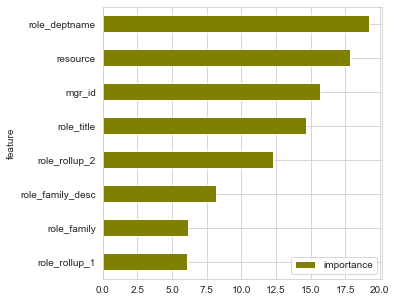

In [109]:
features = pd.DataFrame()
features['feature'] = x_train.columns
features['importance'] = model.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)
features.plot(kind='barh',color="olive", figsize=(5, 5))

**Lets see the evaluation on the kaggle test set**

In [49]:
params = {'loss_function':'Logloss',
          'eval_metric':'AUC',
          'cat_features': cat_features,
          'random_state': 7,
          'iterations':1000,
          "verbose":200
         }
model = CatBoostClassifier(**params)
model.fit(x, y)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Learning rate set to 0.045713
0:	total: 113ms	remaining: 1m 52s
200:	total: 20s	remaining: 1m 19s
400:	total: 47.4s	remaining: 1m 10s
600:	total: 1m 14s	remaining: 49.6s
800:	total: 1m 39s	remaining: 24.6s
999:	total: 2m 2s	remaining: 0us


In [50]:
model.get_best_score()

{'learn': {'Logloss': 0.12149045836812793}}

In [51]:
pred = model.predict_proba(f_test)[:, 1]
pred

array([0.73809857, 0.9898265 , 0.99018161, ..., 0.99372785, 0.96051255,
       0.98720713])

In [52]:
# 91.36% (new best)

submit = pd.DataFrame(columns=["Id","Action"])
submit["Action"] = pred
submit["Id"] = test["id"]
#submit.to_csv('PT7-catboost.csv',index=False)

**Hence we see that with catboost we are able to beat the previous best score of 88.21%. Other than catboost, we can say that with such a feature set with all categorical features (and high cardinality) k-fold target encoding and weight of evidence also gave a very good performance. Specially after incorporating higher order interactions.**